In [200]:
import numpy as np
import pandas as pd
import os
from pathlib import Path
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import pandas as pd
import lightning as L
import pytorch_lightning as pl



In [201]:
for dir_name,_, file_names in os.walk('F:\pycham\PycharmProjects\pythonProject\RNN\Archive'):
    for file_name in file_names:
        paths = os.path.join(dir_name, file_name)
        

In [202]:
path = r'F:\pycham\PycharmProjects\pythonProject\RNN\Archive'
files = Path(path).glob('*.csv')
df = pd.concat((pd.read_csv(f) for f in files), ignore_index=True)

In [203]:
df.head()


,Unnamed: 0,TxnDate,TxnTime,Consumption
0,76229,01 Jan 2022,16:55:52,1.010
1,76258,01 Jan 2022,21:45:29,0.908
2,76287,01 Jan 2022,12:24:52,0.926
3,76316,01 Jan 2022,04:07:36,0.928
4,76345,01 Jan 2022,06:52:25,0.916


In [204]:
df = df.drop(['Unnamed: 0'], axis=1)


In [205]:
df.head()

,TxnDate,TxnTime,Consumption
0,01 Jan 2022,16:55:52,1.010
1,01 Jan 2022,21:45:29,0.908
2,01 Jan 2022,12:24:52,0.926
3,01 Jan 2022,04:07:36,0.928
4,01 Jan 2022,06:52:25,0.916


In [206]:
df['Timestamp'] = pd.to_datetime(df['TxnDate'] + ' ' + df['TxnTime'])
df = df.sort_values('Timestamp')
df.drop(['TxnDate', 'TxnTime'], axis=1, inplace=True)
df

,Consumption,Timestamp
43,1.030,2022-01-01 00:22:28
19,0.904,2022-01-01 00:42:33
25,0.904,2022-01-01 01:01:51
11,1.850,2022-01-01 01:41:48
29,1.878,2022-01-01 02:22:52
...,...,...
3553,1.152,2022-02-28 22:25:43
3568,0.888,2022-02-28 22:44:37
3542,1.064,2022-02-28 23:07:15
3583,1.036,2022-02-28 23:29:13


In [207]:
df.head()
print(f"min date: {df['Timestamp'].min()}, max date: {df['Timestamp'].max()}")
print(f"range: {df['Timestamp'].max()-df['Timestamp'].min()}")

df.describe()

min date: 2022-01-01 00:22:28, max date: 2022-02-28 23:50:27
range: 58 days 23:27:59


,Consumption,Timestamp
count,3606.000000,3606
mean,2.781508,2022-01-30 12:02:06.618691072
min,0.000000,2022-01-01 00:22:28
25%,0.948000,2022-01-15 11:04:40.249999872
50%,1.032000,2022-01-31 03:55:32.500000
75%,4.005500,2022-02-14 05:26:33.249999872
max,27.284000,2022-02-28 23:50:27
std,2.961248,NaN


In [208]:
df.sort_values('Timestamp').rolling('1D',on='Timestamp').sum().head()



,Consumption,Timestamp
43,1.030,2022-01-01 00:22:28
19,1.934,2022-01-01 00:42:33
25,2.838,2022-01-01 01:01:51
11,4.688,2022-01-01 01:41:48
29,6.566,2022-01-01 02:22:52


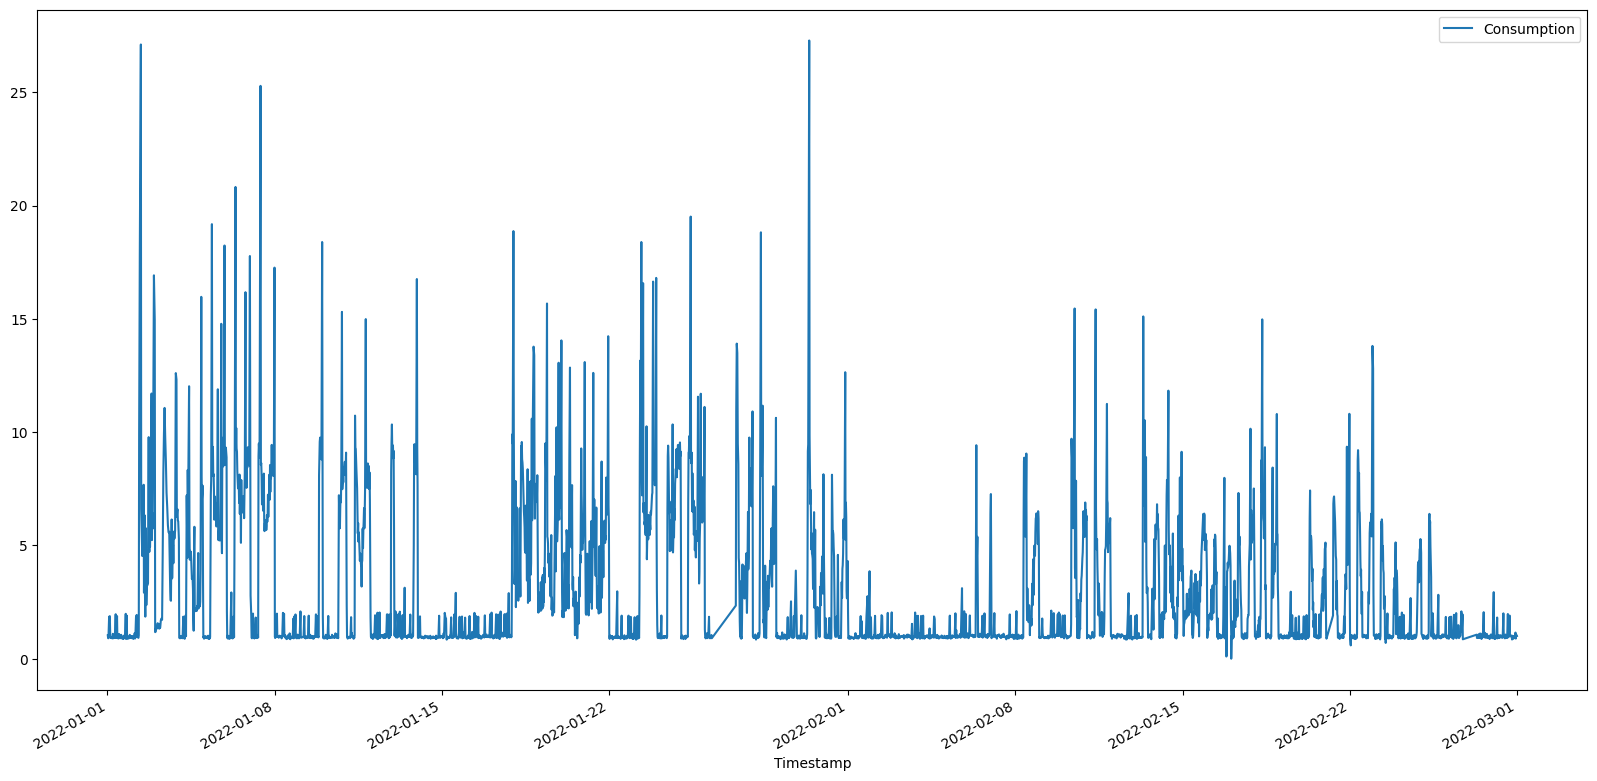

In [209]:
#    draw pylot to show data follow weekly
df.plot(x='Timestamp', y='Consumption', figsize=(20,10))
plt.show()

In [210]:
df_copy = df.set_index('Timestamp').sort_index()
df_copy = df_copy.resample('1B').sum()

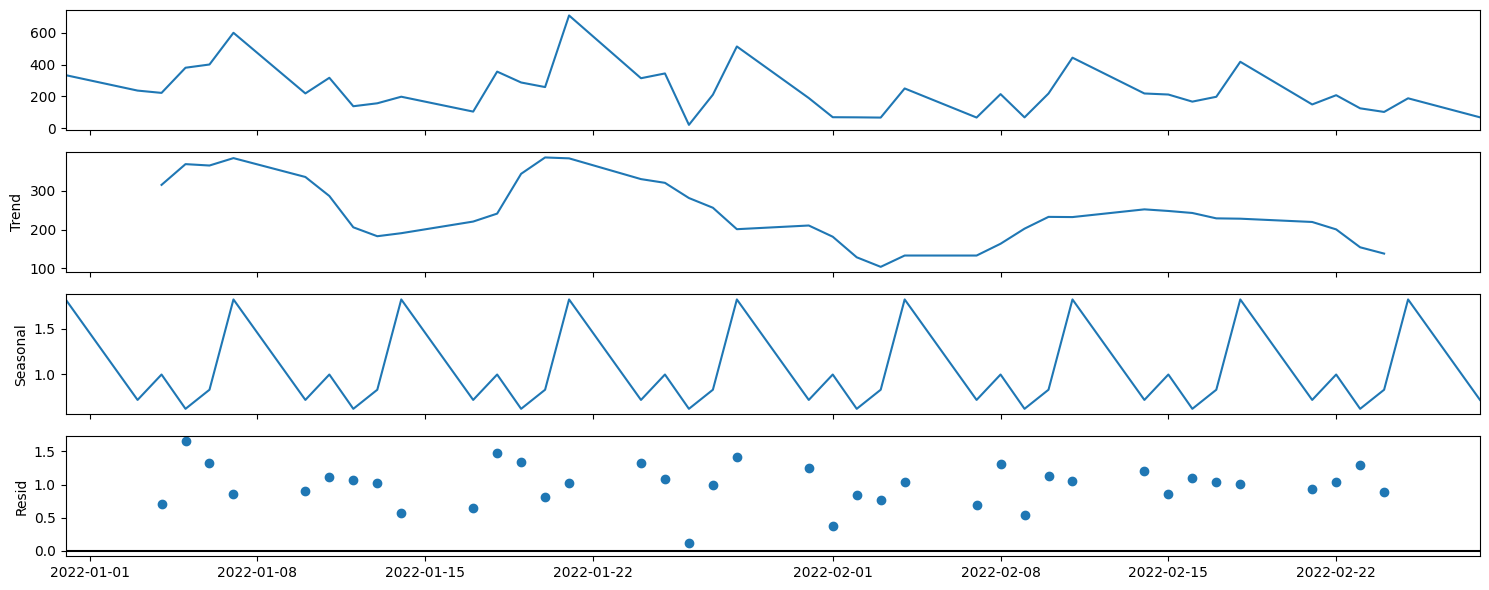

In [211]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(df_copy,model='multiplicative')
plt.rc("figure", figsize=(15,6))
result.plot()
plt.show()

In [212]:
#   Nomalize Consumption to 0-1
df_copy['Consumption'] = df_copy['Consumption']/df_copy['Consumption'].max()
df_copy.head()

,Consumption
Timestamp,
2021-12-31,0.470280
2022-01-03,0.333178
2022-01-04,0.312692
2022-01-05,0.536077
2022-01-06,0.564716


In [213]:
device = torch.device("cuda")
model.cuda()

LSTM()

In [ ]:
plt.plot(df_copy)
plt.show()

In [ ]:
class LSTM(L.LightningModule):
    def __init__(self):
        super().__init__()

        mean = torch.tensor(0.0)
        std = torch.tensor(1.0)
        self.wlr1 = nn.Parameter(torch.normal(mean = mean, std=std), requires_grad=True)
        self.wlr2 = nn.Parameter(torch.normal(mean = mean, std=std), requires_grad=True)
        self.blr1 = nn.Parameter(torch.tensor(0.), requires_grad=True)

        self.wpr1 = nn.Parameter(torch.normal(mean = mean, std=std), requires_grad=True)
        self.wpr2 = nn.Parameter(torch.normal(mean = mean, std=std), requires_grad=True)
        self.bpr1 = nn.Parameter(torch.tensor(0.), requires_grad=True)

        self.wp1 = nn.Parameter(torch.normal(mean = mean, std=std), requires_grad=True)
        self.wp2 = nn.Parameter(torch.normal(mean = mean, std=std), requires_grad=True)
        self.bp1 = nn.Parameter(torch.tensor(0.), requires_grad=True)

        self.wo1 = nn.Parameter(torch.normal(mean = mean, std=std), requires_grad=True)
        self.wo2 = nn.Parameter(torch.normal(mean = mean, std=std), requires_grad=True)
        self.bo1 = nn.Parameter(torch.tensor(0.), requires_grad=True)
    def lstm_unit(self, input_value, long_memory, short_memory):
        long_remember_percent = torch.sigmoid((self.wlr1 * short_memory) +
                                               (self.wlr2 * input_value) +
                                                self.blr1)
        potential_remember_percent = torch.sigmoid((self.wpr1 * short_memory) +
                                                  (self.wpr2 * input_value) +
                                                    self.bpr1)
        potential_memory = torch.tanh((self.wp1 * short_memory) +
                                        (self.wp2 * input_value) +
                                        self.bp1)
        updated_long_memory = (long_memory * long_remember_percent) + (potential_memory * potential_remember_percent)
        output_percent = torch.sigmoid((self.wo1 * short_memory) +
                                        (self.wo2 * input_value) +
                                        self.bo1)
        updated_short_memory = torch.tanh(updated_long_memory) * output_percent
        return updated_long_memory, updated_short_memory
        
    def forward(self, input):
        long_memory = torch.zeros(1)
        short_memory = torch.zeros(1)
        for i in range(input.shape[0]):
            long_memory, short_memory = self.lstm_unit(input[i], long_memory, short_memory)
        return short_memory
    def configure_optimizers(self):
        return Adam(self.parameters(), lr=1e-3)
    def training_step(self, batch, batch_idx):
        input_i, lable_i = batch
        output_i = self.forward(input_i[0])
        loss = F.mse_loss(output_i, lable_i)
        self.log('train_loss', loss)

        if (lable_i == 0):
            self.log("out_0", output_i)
        else:
            self.log("out_1", output_i)
        return loss    


In [ ]:
df_copy.describe()

In [ ]:
train_data = df_copy["Consumption"].iloc[:35]  
test_data = df_copy["Consumption"].iloc[35:]

train_data = torch.tensor([train_data.values], dtype=torch.float32)
test_data = torch.tensor([test_data.values], dtype=torch.float32)
test_data

In [ ]:
model = LSTM().to('cuda')
input = train_data
lable = test_data
dataset = TensorDataset(input, lable)
dataloader = DataLoader(dataset)
model.cuda()
trainer = L.Trainer(max_epochs=2000)
trainer.fit(model, dataloader)


In [ ]:
model.cuda()
trainer = L.Trainer(max_epochs=2000)
trainer.fit(model, dataloader)

In [ ]:
model = LSTM()
print(
    model(torch.tensor(df_copy["Consumption"])).detach())
# Use Pytorch Lightning to train model use 30 days to predict 7 day Consumption
train_dataset = L.(df_copy["Consumption"], 30, 7)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=False)
trainer = L.Trainer(max_epochs=100)
trainer.fit(model, train_loader)
